# Superstore Sales Workflow Tutorial

This notebook walks through cleaning the Superstore dataset, designing a relational structure, creating an SQLite database, and running example SQL queries and visualizations.

In [136]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import textwrap


## 1️) Load and Inspect the Dataset

In [137]:
# reading error codes + research is how you can learn if there is different encoding, as seen below
df = pd.read_csv('../data/Superstore.csv', encoding='ISO-8859-1')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2013-152156,09-11-2013,12-11-2013,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2013-152156,09-11-2013,12-11-2013,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2013-138688,13-06-2013,17-06-2013,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2012-108966,11-10-2012,18-10-2012,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2012-108966,11-10-2012,18-10-2012,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


### Double check some datatypes, and for nulls and duplicates:

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [139]:
df.duplicated().sum()

np.int64(0)

In [140]:
df.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

This data is incredibly clean - we can see there are no null values and no duplicates. However, there are some dates that could be saved in a better format.

## 2) Data Cleaning

In [141]:
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True)
df['Ship Date'] = pd.to_datetime(df['Ship Date'], dayfirst=True)

In [142]:
df.dtypes

Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object

In [143]:
df.Segment.unique()

array(['Consumer', 'Corporate', 'Home Office'], dtype=object)

In [144]:
df.rename(columns={"Segment":"customer_category"}, inplace=True)
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,customer_category,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2013-152156,2013-11-09,2013-11-12,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2013-152156,2013-11-09,2013-11-12,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2013-138688,2013-06-13,2013-06-17,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2012-108966,2012-10-11,2012-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2012-108966,2012-10-11,2012-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


With real data, it is very likely more cleaning and wrangling would be required. 

## 3) Build Relational Tables

In [145]:
conn = sqlite3.connect('../data/superstore.db')

customers_df = df[['Customer ID','Customer Name','customer_category','City','State','Region']].drop_duplicates().rename(columns={
    'Customer ID':'customer_id',
    'Customer Name':'customer_name',
    'City':'city',
    'State':'state',
    'Region':'region',
    'Postal Code':'postal_code'
})

products_df = df[['Product ID','Category','Sub-Category','Product Name']].drop_duplicates().rename(columns={
    'Product ID':'product_id',
    'Category':'category',
    'Sub-Category':'subcategory',
    'Product Name':'product_name'
})

orders_df = df[['Order ID','Order Date','Ship Date','Ship Mode','Customer ID']].drop_duplicates().rename(columns={
    'Order ID':'order_id',
    'Order Date':'order_date',
    'Ship Date':'ship_date',
    'Ship Mode':'ship_mode',
    'Customer ID':'customer_id'
})

order_details_df = df[['Order ID','Product ID','Sales','Quantity','Discount','Profit']].rename(columns={
    'Order ID':'order_id',
    'Product ID':'product_id', 
    'Quantity':'quantity', 
    'Discount':'discount', 
    'Profit':'profit'
})

customers_df.to_sql('customers', conn, index=False, if_exists='replace')
products_df.to_sql('products', conn, index=False, if_exists='replace')
orders_df.to_sql('orders', conn, index=False, if_exists='replace')
order_details_df.to_sql('order_details', conn, index=False, if_exists='replace')
conn.commit()

## 4) Make Some Queries!

### Which customer segments bring in the most revenue and profit?

In [146]:
query1 = """ SELECT 
    c.customer_category,
    ROUND(SUM(od.sales), 2) AS total_sales,
    ROUND(SUM(od.profit), 2) AS total_profit
FROM order_details od
JOIN orders o ON od.order_id = o.order_id
JOIN customers c ON o.customer_id = c.customer_id
GROUP BY c.customer_category
ORDER BY total_sales DESC;
"""
result1 = pd.read_sql(query1, conn)
result1

,customer_category,total_sales,total_profit
0,Consumer,7954360.98,923657.52
1,Corporate,4768494.07,622614.73
2,Home Office,2808676.56,403920.45


### What are the top 10 customers by total sales?

In [147]:
query2 = """ 

Select c.customer_name, 
    ROUND(SUM(od.sales), 2) as total_sales    
from customers c
JOIN orders o
    on c.customer_id = o.customer_id
Join order_details od
    on o.order_id = od.order_id
group by c.customer_name
order by total_sales DESC
limit 10;"""
result2 = pd.read_sql(query2, conn)
result2

,customer_name,total_sales
0,Ken Lonsdale,141752.29
1,Sanjit Engle,134303.82
2,Adrian Barton,130262.14
3,Sean Miller,125215.25
4,Clay Ludtke,119686.01
5,Sanjit Chand,113138.67
6,Seth Vernon,103238.55
7,Zuschuss Carroll,96308.48
8,Maria Etezadi,95973.55
9,Laura Armstrong,95405.44


### Which product categories and subcategories are the most profitable overall?

In [148]:
query3 = """ 

Select 
    p.category, 
    p.subcategory, 
    ROUND(SUM(od.profit), 2) as total_profit
from products p
Join order_details od
    on p.product_id = od.product_id
Group by p.category, p.subcategory
order by total_profit desc
limit 10;

 """
result3 = pd.read_sql(query3, conn)
result3

,category,subcategory,total_profit
0,Technology,Copiers,55617.82
1,Technology,Accessories,48359.05
2,Technology,Phones,46936.19
3,Office Supplies,Paper,36994.53
4,Office Supplies,Binders,30373.20
5,Furniture,Chairs,26707.65
6,Office Supplies,Storage,21408.70
7,Office Supplies,Appliances,18514.49
8,Furniture,Furnishings,14569.59
9,Office Supplies,Envelopes,6964.18


### What is the average discount given per category?

In [149]:
query4 = """ 

Select p.category, ROUND(AVG(od.discount), 2) as avg_discount
from products p
JOIN order_details od
    on p.product_id = od.product_id
group by p.category;"""
result4 = pd.read_sql(query4, conn)
result4

,category,avg_discount
0,Furniture,0.17
1,Office Supplies,0.16
2,Technology,0.13


### Which states or regions contribute the most to total sales?

In [150]:
query5 = """ 

Select c.region, 
    ROUND(SUM(od.sales), 2) as total_sales    
from customers c
JOIN orders o
    on c.customer_id = o.customer_id
Join order_details od
    on o.order_id = od.order_id
group by c.region
order by total_sales DESC;  """
result5 = pd.read_sql(query5, conn)
result5

,region,total_sales
0,West,4905329.07
1,East,4164298.93
2,Central,3755466.07
3,South,2706437.54


### How many orders were shipped late (where Ship Date > Order Date + 3 days)?

In [151]:
query6 = """ 

Select 
    Count(*) AS orders_shipped_late
from orders
Where ship_date > DATE(order_date, '+3 days'); """
result6 = pd.read_sql(query6, conn)
result6

,orders_shipped_late
0,3902


### Which month or year had the highest total sales?

In [152]:
#chatgpt assisted to be able to find Month/Year

query7 = """ 

Select 
    STRFTIME('%Y-%m', o.order_date) AS order_month,
    ROUND(SUM(od.sales), 2) as total_sales
From order_details od
Join orders o
    ON od.order_id = o.order_id
Group by order_month
Order by total_sales DESC
Limit 20;
 """
result7 = pd.read_sql(query7, conn)
result7

,order_month,total_sales
0,2014-11,112326.47
1,2013-12,97237.42
2,2014-09,90488.72
3,2014-12,90474.60
4,2013-11,82192.32
5,2011-09,81777.35
6,2011-11,78628.72
7,2014-10,77793.76
8,2012-11,75972.56
9,2012-12,74919.52


### What are the most frequently ordered products?

In [153]:
query8 = """ 

Select p.product_name, 
    ROUND(SUM(od.sales), 2) as total_sales
 from products p
 Join order_details od
    ON p.product_id = od.product_id
Group by product_name
Order by total_sales DESC
limit 10;

"""
result8 = pd.read_sql(query8, conn)
result8

,product_name,total_sales
0,Canon imageCLASS 2200 Advanced Copier,61599.82
1,Fellowes PB500 Electric Punch Plastic Comb Bin...,27453.38
2,Cisco TelePresence System EX90 Videoconferenci...,22638.48
3,HON 5400 Series Task Chairs for Big and Tall,21870.58
4,GBC DocuBind TL300 Electric Binding System,19823.48
5,GBC Ibimaster 500 Manual ProClick Binding System,19024.50
6,Hewlett Packard LaserJet 3310 Copier,18839.69
7,HP Designjet T520 Inkjet Large Format Printer ...,18374.90
8,GBC DocuBind P400 Electric Binding System,17965.07
9,High Speed Automatic Electric Letter Opener,17030.31


### Which customers placed more than 5 orders total?

In [154]:
query9 = """ 

Select c.customer_name, COUNT(o.order_id) as total_orders
from customers c
join orders o
    on c.customer_id = o.customer_id
group by c.customer_name
having total_orders > 5
order by total_orders DESC;
"""
result9 = pd.read_sql(query9, conn)
result9

,customer_name,total_orders
0,Emily Phan,255
1,Joel Eaton,169
2,Zuschuss Carroll,156
3,Noel Staavos,156
4,Erin Ashbrook,156
...,...,...
742,Barry Weirich,9
743,Astrea Jones,9
744,Alyssa Crouse,9
745,Aaron Bergman,9


### What’s the profit margin (profit ÷ sales) by category or segment?

In [155]:
query10 = """ 

select p.category, Round(sum(od.profit) / sum(od.sales), 2 ) as profit_margin
from products p
join order_details od
    on p.product_id = od.product_id
group by p.category
order by profit_margin DESC
;
 """
result10 = pd.read_sql(query10, conn)
result10

,category,profit_margin
0,Technology,0.17
1,Office Supplies,0.17
2,Furniture,0.03


### 5) Visualize it!

From your ten results, select at least 4 to utilize in a meaningful visualization. 

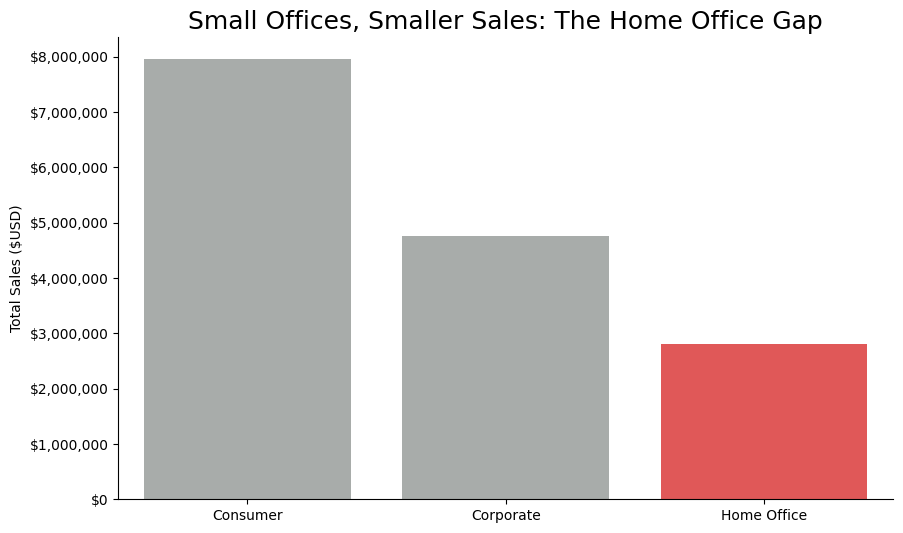

In [156]:
# example using result1
plt.figure(figsize=(10,6))
colors = ["#a7adaa", "#a7adaa", "#f74141" ]
sns.barplot(result1, x='customer_category', y='total_sales', palette=colors, hue='customer_category', legend=False)
plt.title('Small Offices, Smaller Sales: The Home Office Gap',fontsize=18)
plt.xlabel(None)
plt.ylabel('Total Sales ($USD)')

#for those wondering how to get rid of scientific notation! Set style to plain:
plt.ticklabel_format(style='plain', axis='y')

#mticker is a great library for helping tick mark formatting, such as adding commas and dollar signs in this case
ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))

#using the seaborn library, despining is way easier!
sns.despine()
plt.show()


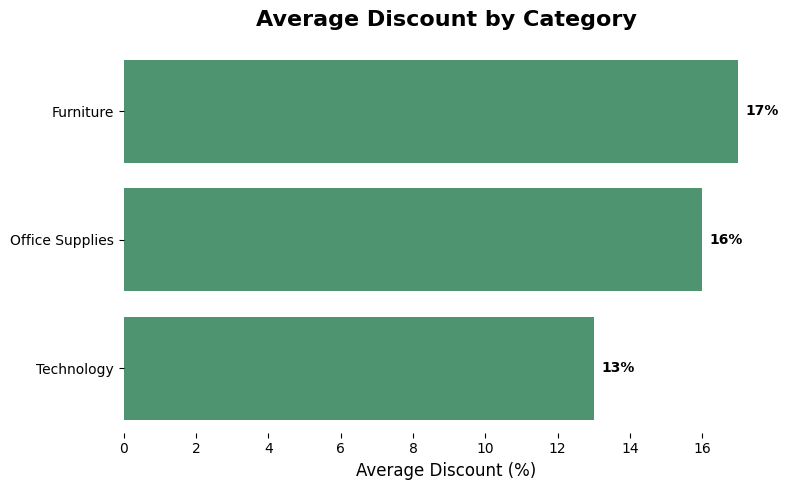

In [157]:

#Query4

import seaborn as sns
import matplotlib.pyplot as plt

# Create a copy with percentage values for display
result4['avg_discount_pct'] = result4['avg_discount'] * 100

plt.figure(figsize=(8, 5))
sns.barplot(
    data=result4,
    y='category',
    x='avg_discount_pct',
    color='#43a071'
)

plt.title('Average Discount by Category', fontsize=16, weight='bold', pad=15)
plt.xlabel('Average Discount (%)', fontsize=12)
plt.ylabel(None)


for i, v in enumerate(result4['avg_discount_pct']):
    plt.text(
        v + 0.2,                
        i, 
        f'{v:.0f}%',            
        va='center',
        fontsize=10,
        weight='bold',
        color='black'
    )

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()




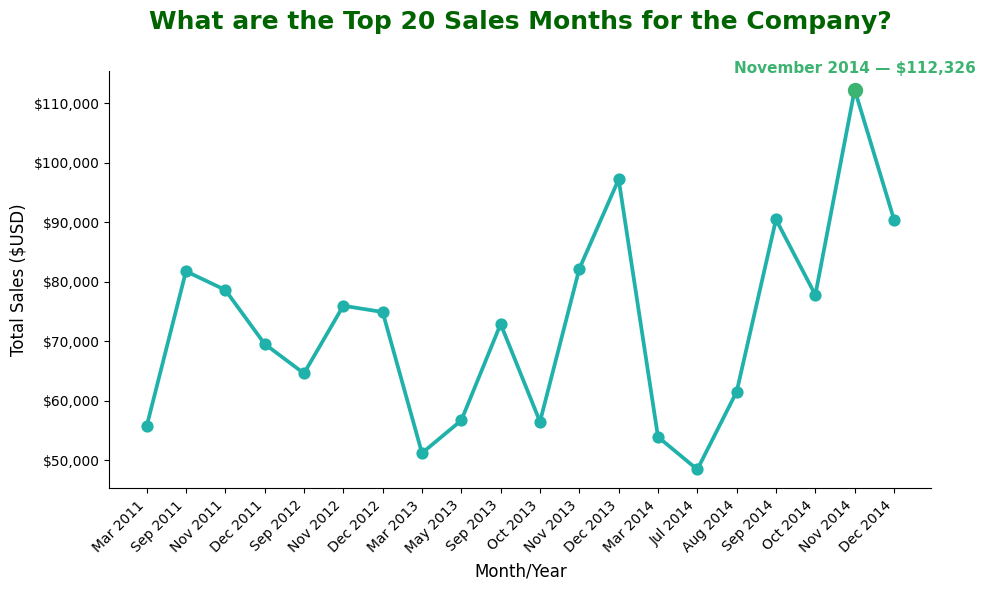

In [158]:
# visualization two code here- Chat GPT assisted to change label of month- QUERY 7

result7['order_month'] = pd.to_datetime(result7['order_month'])
result7 = result7.sort_values('order_month')

result7['month_label'] = result7['order_month'].dt.strftime('%b %Y')

plt.figure(figsize=(10,6))

ax = sns.pointplot(
    data=result7,
    x='month_label',
    y='total_sales',
    color='lightseagreen',
    legend=False
)

plt.title('What are the Top 20 Sales Months for the Company?', color= 'darkgreen',pad=30, fontsize=18, weight='bold')
plt.xlabel('Month/Year', fontsize=12)
plt.ylabel('Total Sales ($USD)', fontsize=12)

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))


top_idx = result7['total_sales'].idxmax()
top_label = result7.loc[top_idx, 'month_label']
top_y = result7.loc[top_idx, 'total_sales']
month_label = result7.loc[top_idx, 'order_month'].strftime('%B %Y')

x_positions = range(len(result7))
top_pos = list(result7['month_label']).index(top_label)

ax.scatter(top_pos, top_y, color='mediumseagreen', s=100, zorder=3)
ax.text(
    top_pos,
    top_y + (top_y * 0.02),
    f'{month_label} — ${top_y:,.0f}',
    color='mediumseagreen',
    weight='bold',
    ha='center',
    va='bottom',
    fontsize=11
)

plt.xticks(rotation=45, ha='right')
sns.despine()
plt.tight_layout()
plt.show()


C:\Users\laure\AppData\Local\Temp\ipykernel_20424\293541110.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


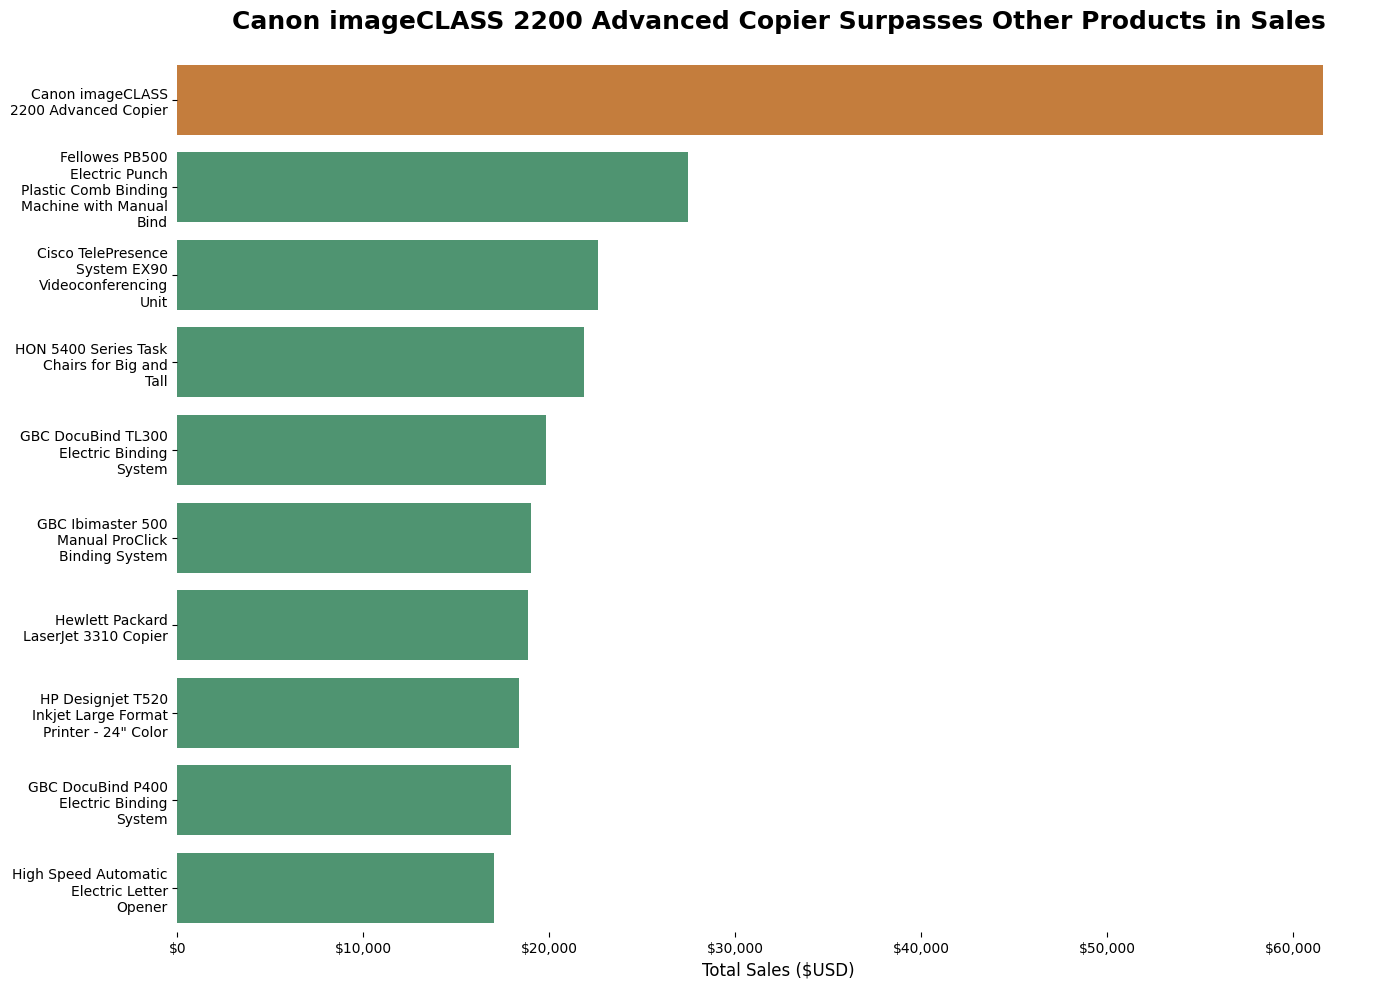

In [159]:
# visualization three code here- Query8

result8['wrapped_name'] = result8['product_name'].apply(
    lambda x: '\n'.join(textwrap.wrap(x, width=20))
)

top_product = result8.loc[result8['total_sales'].idxmax(), 'wrapped_name']
colors = [
    '#db7c26' if name == top_product else '#43a071' 
    for name in result8['wrapped_name']
]

plt.figure(figsize=(14, 10))
sns.barplot(
    data=result8,
    y='wrapped_name',
    x='total_sales',
    palette=colors 
)

plt.title('Canon imageCLASS 2200 Advanced Copier Surpasses Other Products in Sales', pad = 20, fontsize=18, weight='bold')
plt.xlabel('Total Sales ($USD)', fontsize=12)
plt.ylabel(None)

ax = plt.gca()
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

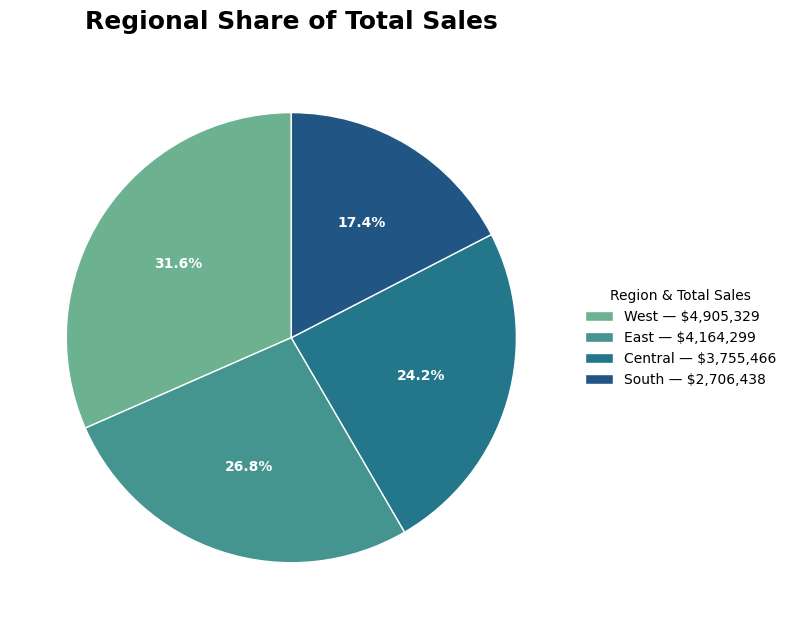

In [160]:
# Query5

result5 = result5.sort_values('total_sales', ascending=False)

colors = sns.color_palette('crest', n_colors=len(result5))

fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    result5['total_sales'],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'color': 'white', 'weight': 'bold', 'fontsize': 10},
    wedgeprops={'edgecolor': 'white'}
)

ax.legend(
    [f"{r} — ${s:,.0f}" for r, s in zip(result5['region'], result5['total_sales'])],
    title="Region & Total Sales",
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=False
)

plt.title('Regional Share of Total Sales', fontsize=18, weight='bold', pad=20)
plt.tight_layout()
plt.show()

